In [9]:
# standard libraries
import re, gzip, os, platform, multiprocessing
from io import StringIO

# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import sklearn.svm
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.decomposition

import os, platform, importlib
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
from scripts import processData, files
importlib.reload(processData)
importlib.reload(files)

paths = files.getPaths()
os.chdir(paths['dirProject'])
print("Current working directory: " + os.getcwd())

Current working directory: /home/users/bentyeh/projects/disprot


## Read data and data pre-processing

In [15]:
reprocess = True
show_df = True

Datasets (training and test) from [Perovic et al.](https://doi.org/10.1038/s41598-018-28815-x)

In [16]:
xlsx = pd.ExcelFile(paths['IDPpi_datasets'])
num_datasets = 5
for i in range(num_datasets):
    # many sheet names have trailing whitespace
    train_sheet_name = 'Table S' + str(i+7) + '-DisorderTrainSet' + str(i+1)
    train_sheet_name = np.where([name.startswith(train_sheet_name) for name in xlsx.sheet_names])[0][0]
    test_sheet_name = 'Table S' + str(i+12) + '-DisorderTestSet' + str(i+1)
    test_sheet_name = np.where([name.startswith(test_sheet_name) for name in xlsx.sheet_names])[0][0]
    
    train_set = pd.read_excel(xlsx, sheet_name=train_sheet_name)
    train_set = train_set.iloc[:,0].str.split(expand=True)
    train_set.columns = ['label', 'p1_uniprotName', 'p2_uniprotName']
    
    test_set = pd.read_excel(xlsx, sheet_name=test_sheet_name)
    test_set = test_set.iloc[:,0].str.split(expand=True)
    test_set.columns = ['label', 'p1_uniprotName', 'p2_uniprotName']
    
    if reprocess:
        train_set.to_csv(paths['IDPpi_set'].format('train', i+1), **files.save_kwargs)
        test_set.to_csv(paths['IDPpi_set'].format('test', i+1), **files.save_kwargs)
del xlsx

## Featurization

Requires R package protr

# Training

In [34]:
regex_train_features = re.compile(r'train_features\d+')
regex_train_labels = re.compile(r'train_labels\d+')
regex_test_features = re.compile(r'test_features\d+')
regex_test_labels = re.compile(r'test_labels\d+')

datasets_train = list(zip(sorted(list(filter(regex_train_features.match, os.listdir(paths['dirDataML'])))),
                          sorted(list(filter(regex_train_labels.match, os.listdir(paths['dirDataML']))))))
datasets_test = list(zip(sorted(list(filter(regex_test_features.match, os.listdir(paths['dirDataML'])))),
                         sorted(list(filter(regex_test_labels.match, os.listdir(paths['dirDataML']))))))

nDatasets = len(datasets_train)

display(datasets_train)
display(datasets_test)

[('train_features01.tsv.gz', 'train_labels01.txt.gz'),
 ('train_features02.tsv.gz', 'train_labels02.txt.gz'),
 ('train_features03.tsv.gz', 'train_labels03.txt.gz'),
 ('train_features04.tsv.gz', 'train_labels04.txt.gz'),
 ('train_features05.tsv.gz', 'train_labels05.txt.gz')]

[('test_features01.tsv.gz', 'test_labels01.txt.gz'),
 ('test_features02.tsv.gz', 'test_labels02.txt.gz'),
 ('test_features03.tsv.gz', 'test_labels03.txt.gz'),
 ('test_features04.tsv.gz', 'test_labels04.txt.gz'),
 ('test_features05.tsv.gz', 'test_labels05.txt.gz')]

## Data Visualization

In [4]:
X_train = []
Y_train = []
X_test = []
Y_test = []

for i in range(nDatasets):
    X_train_file, Y_train_file = datasets_train[i]
    X_test_file, Y_test_file = datasets_test[i]
    X_train.append(pd.read_table(os.path.join(paths['dirDataML'], X_train_file), header=0).values)
    Y_train.append(pd.read_table(os.path.join(paths['dirDataML'], Y_train_file), header=None).squeeze().values)
    X_test.append(pd.read_table(os.path.join(paths['dirDataML'], X_test_file),  header=0).values)
    Y_test.append(pd.read_table(os.path.join(paths['dirDataML'], Y_test_file), header=None).squeeze().values)

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
Y_train = np.hstack(Y_train)
Y_test = np.hstack(Y_test)

X_train, uniqIndices_train = np.unique(X_train, axis=0, return_index=True)
X_test, uniqIndices_test = np.unique(X_test, axis=0, return_index=True)
Y_train = Y_train[uniqIndices_train]
Y_test = Y_test[uniqIndices_test]

pca = sklearn.decomposition.PCA(n_components=4).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

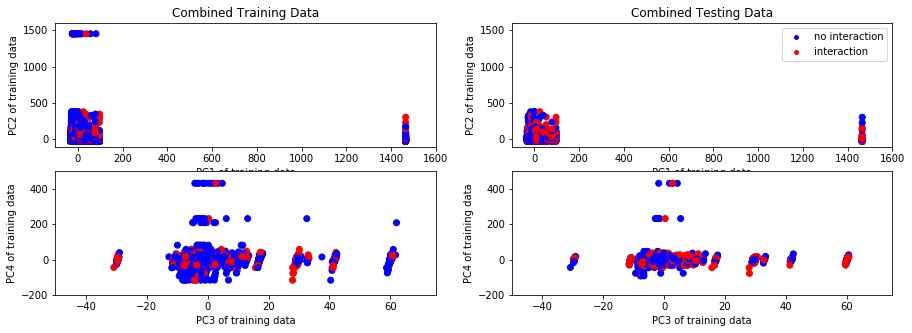

In [20]:
colors = np.array(['blue', 'red'])
labels = ['no interaction', 'interaction']
fig_pca, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
axs[0,0].scatter(X_train_pca[:,0], X_train_pca[:,1], color=colors[Y_train])
axs[0,0].set_xlabel('PC1 of training data')
axs[0,0].set_ylabel('PC2 of training data')
axs[0,0].set_xlim([-100,1600])
axs[0,0].set_ylim([-100,1600])
axs[0,0].set_title('Combined Training Data')
axs[0,1].scatter(X_test_pca[:,0], X_test_pca[:,1], color=colors[Y_test])
axs[0,1].set_xlabel('PC1 of training data')
axs[0,1].set_ylabel('PC2 of training data')
axs[0,1].set_xlim([-100,1600])
axs[0,1].set_ylim([-100,1600])
axs[0,1].set_title('Combined Testing Data')
legend_elements = [Line2D([0],[0], marker='o', color='w', label='no interaction', markerfacecolor='b'),
                   Line2D([0],[0], marker='o', color='w', label='interaction', markerfacecolor='r')]
axs[0,1].legend(handles=legend_elements, loc='best')

axs[1,0].scatter(X_train_pca[:,2], X_train_pca[:,3], color=colors[Y_train])
axs[1,0].set_xlabel('PC3 of training data')
axs[1,0].set_ylabel('PC4 of training data')
axs[1,0].set_xlim([-50,75])
axs[1,0].set_ylim([-200,500])
axs[1,1].scatter(X_test_pca[:,2], X_test_pca[:,3], color=colors[Y_test])
axs[1,1].set_xlabel('PC3 of training data')
axs[1,1].set_ylabel('PC4 of training data')
axs[1,1].set_xlim([-50,75])
axs[1,1].set_ylim([-200,500])

fig.tight_layout()
fig_pca.savefig(os.path.join(paths['dirResults_mlPlots'], 'pca.png'))

# Training

In [33]:
models = [sklearn.linear_model.LogisticRegression(),
          sklearn.ensemble.RandomForestClassifier(n_estimators = 100),
          sklearn.svm.LinearSVC(),
          sklearn.svm.SVC()]
models_names = ['Logistic Regression', 'Random Forest Classifier', 'SVM (Linear)', 'SVM (RBF)']
nModels = len(models)

In [ ]:
results = [[None]*nDatasets]*nModels
figs = [None]*nModels
pool = multiprocessing.Pool(len(os.sched_getaffinity(0)))

for j in range(nDatasets):
    X_train_file, Y_train_file = datasets_train[j]
    X_test_file, Y_test_file = datasets_test[j]

    X_train = pd.read_table(os.path.join(paths['dirDataML'], X_train_file), header=0).values
    Y_train = pd.read_table(os.path.join(paths['dirDataML'], Y_train_file), header=None).squeeze().values
    X_test = pd.read_table(os.path.join(paths['dirDataML'], X_test_file),  header=0).values
    Y_test = pd.read_table(os.path.join(paths['dirDataML'], Y_test_file), header=None).squeeze().values

    for i in range(nModels):
        model = models[j]
        figs.append(plt.figure())
    
        fpr, tpr, thresh, roc_auc = fitAndEval(X_train, Y_train, X_test, Y_test, model)
        plt.plot(fpr, tpr, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.legend()
    figs[i].savefig(os.path.join(paths['dirResults_mlPlots'], models_names[i] + '.png'))
plt.show()

In [ ]:
for j in range(nModels):
    model = models[j]
    figs.append(plt.figure())
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(models_names[i])
    
            plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title(models_names[i])

/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-

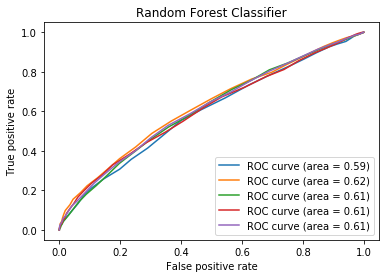

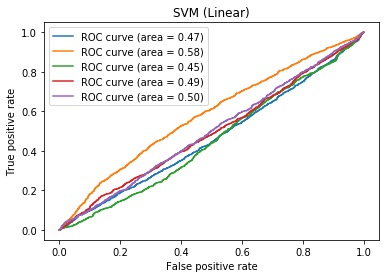

In [30]:
models = [sklearn.linear_model.LogisticRegression(),
          sklearn.ensemble.RandomForestClassifier(n_estimators = 100),
          sklearn.svm.LinearSVC(),
          sklearn.svm.SVC()]
models_names = ['Logistic Regression', 'Random Forest Classifier', 'SVM (Linear)', 'SVM (RBF)']
figs = []
for i in range(len(models)):
    model = models[i]
    figs.append(plt.figure())
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(models_names[i])
    for j in range(len(datasets_train)):
        X_train_file, Y_train_file = datasets_train[j]
        X_test_file, Y_test_file = datasets_test[j]

        X_train = pd.read_table(os.path.join(paths['dirDataML'], X_train_file), header=0).values
        Y_train = pd.read_table(os.path.join(paths['dirDataML'], Y_train_file), header=None).squeeze().values
        X_test = pd.read_table(os.path.join(paths['dirDataML'], X_test_file),  header=0).values
        Y_test = pd.read_table(os.path.join(paths['dirDataML'], Y_test_file), header=None).squeeze().values
        
        fpr, tpr, thresh, roc_auc = fitAndEval(X_train, Y_train, X_test, Y_test, model)
        plt.plot(fpr, tpr, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.legend()
    figs[i].savefig(os.path.join(paths['dirResults_mlPlots'], models_names[i] + '.png'))
plt.show()

In [31]:
figs[0].set_size_inches(4,4)
figs[0].savefig(os.path.join(paths['dirResults_mlPlots'], 'Random Forest Classifier_resized.png'), dpi=300)

figs[1].set_size_inches(4,4)
figs[1].savefig(os.path.join(paths['dirResults_mlPlots'], 'SVM Linear_resized.png'), dpi=300)